# SARIMA Model for Forecasting Bitcoin Transaction Fees (Next 24 Hours)

This notebook builds and evaluates a SARIMA model to forecast the **Bitcoin transaction fee** over the **next 24 hours**. 

### Why SARIMA?

During exploratory data analysis (EDA), we identified:
- **Daily seasonality patterns** in transaction fees (24-hour cycle),
- **Strong autocorrelation**, indicating temporal dependence.

Given these findings, the SARIMA model is an appropriate choice as it can model:
- Autoregressive and moving average components,
- **Seasonal effects**, such as daily cyclic behavior.

This notebook walks through the full modeling pipeline using SARIMA.


In [1]:
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, temporal_train_test_split)
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sktime.forecasting.model_evaluation import evaluate
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading

We begin by loading the preprocessed dataset specifically prepared for SARIMA and HWES models.


In [6]:
df = pd.read_parquet('../data/processed/preprocessed_sarima_hwes.parquet')
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11901 entries, 2025-03-05 02:10:00 to 2025-04-15 09:50:00
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mempool_blocks_blockSize                  11901 non-null  float64
 1   mempool_blocks_blockVSize                 11901 non-null  float64
 2   mempool_blocks_nTx                        11901 non-null  float64
 3   mempool_blocks_totalFees                  11901 non-null  float64
 4   mempool_blocks_medianFee                  11901 non-null  float64
 5   recommended_fee_fastestFee                11901 non-null  float64
 6   recommended_fee_halfHourFee               11901 non-null  float64
 7   recommended_fee_hourFee                   11901 non-null  float64
 8   recommended_fee_economyFee                11901 non-null  float64
 9   recommended_fee_minimumFee                11901 non-null  float64
 10 

# 2. Autocorrelation, Partial Autocorrelation Analysis and Stationarity Check (ADF Test)

To determine the appropriate AR (autoregressive) and MA (moving average) orders, we examine the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** of the target variable. Before fitting a SARIMA model, we need to verify if the time series is **stationary** — a key assumption for ARIMA-family models. We use the **Augmented Dickey-Fuller (ADF) test**, which tests the null hypothesis that the time series has a unit root (i.e., is non-stationary).

(11901,)

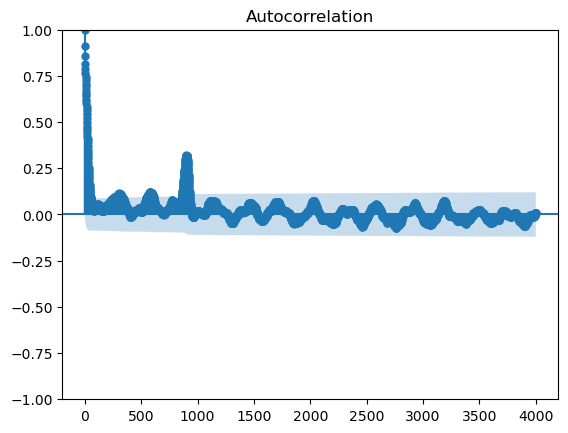

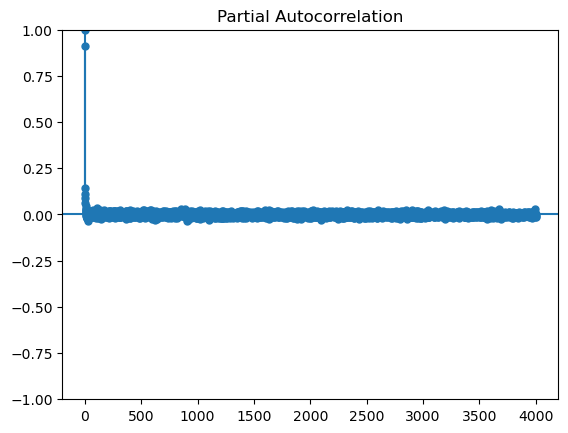

In [3]:
y = df["recommended_fee_fastestFee"]
plot_acf(y, lags=4000)   
plot_pacf(y, lags=4000)
y.shape

In [4]:
adfuller(y)[1]

np.float64(1.0896816913186839e-24)

The PACF cuts off at lag 1 and the ACF shows a significant lag-1 with slow decay, suggesting an ARIMA(1, 0, 1) structure. Clear seasonal spikes at lag 288 in the ACF indicate a seasonal pattern, so we set the seasonal order to (1, 0, 1, 288)

## 3. Sampling and Splitting (Last 7 Days)

To reduce computational cost, we focus on the **most recent 7 days**

In [5]:
#sample 30 days data due to computational resource

end_date = y.index.max()
start_date = end_date - pd.Timedelta(days=30)
y_month = y.loc[start_date:end_date]
y_train, y_test = temporal_train_test_split(y_month, test_size=288)
# Log-transform training data to stabilize variance and outliers
y_train_log = np.log1p(y_train)

y_train.shape

(8353,)

## 4. Define Forecast Horizon and Fit SARIMA Model

We now initialize the SARIMA model and fit it on the log-transformed training data.

In [6]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [7]:
# cross validation if available
# desired_folds = 5
# total_len = len(y)
# fh_max = 288

# step_length = (total_len - 2000 - fh_max) // (desired_folds - 1)
# cv = ExpandingWindowSplitter(
#     initial_window = 2000,
#     fh=fh,
#     step_length=step_length 
# )
# cross validate
# results = evaluate(
#     forecaster=forecaster,
#     y=y,
#     cv=cv,
#     strategy="update",
#     scoring=[mean_squared_error, mean_absolute_percentage_error],
#     return_data=True
# )

In [8]:
forecaster = ARIMA(
    order=(1, 0, 1),                
    seasonal_order=(1, 0, 1, 288)  
)

In [9]:
forecaster.fit(y_train_log)

ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 288))

# 5. Forecasting and Evaluation

After fitting the SARIMA model, we generate forecasts and evaluate performance using RMSE and MAPE.


In [10]:
y_pred_log = forecaster.predict(fh)
y_pred = np.expm1(y_pred_log)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE on 24h test set: {rmse:.4f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on 24h test set: {mae:.4f}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE on 24h test set: {mape:.4f}")

RMSE on 24h test set: 1.9267
MAE on 24h test set: 1.1683
MAPE on 24h test set: 0.6674


# 6. Forecast Visualization

We visualize the SARIMA model’s forecast against the actual log-transformed values over the test period.

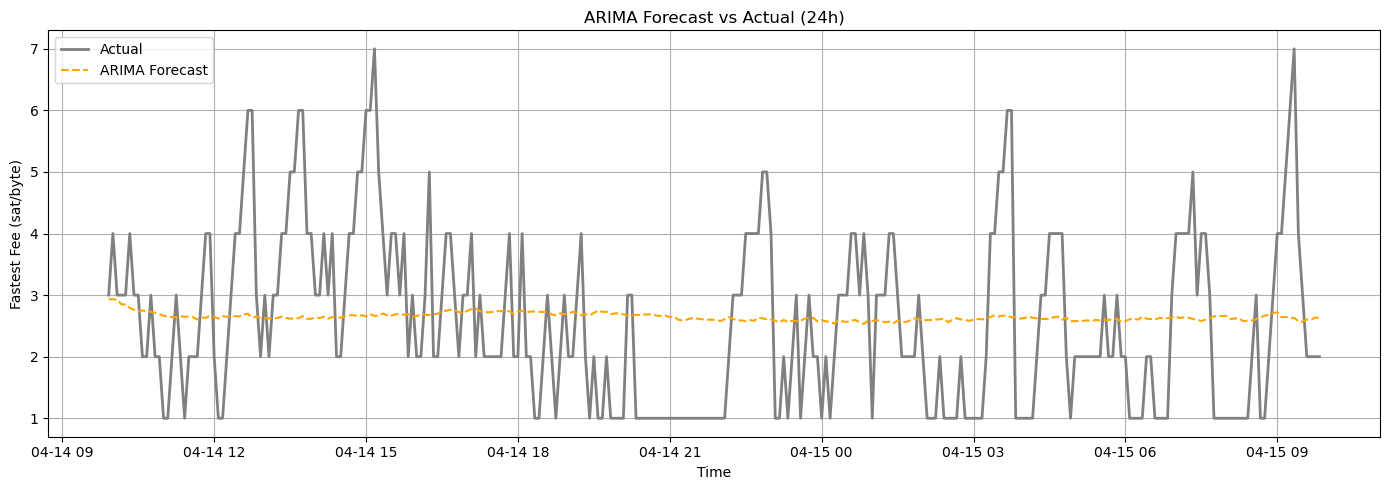

In [11]:

plt.figure(figsize=(14, 5))

# Plot actual values
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2, color = "grey")
# Plot predicted values
plt.plot(y_pred.index, y_pred.values, label="ARIMA Forecast", linestyle="--", color="orange")

plt.title("ARIMA Forecast vs Actual (24h)")
plt.xlabel("Time")
plt.ylabel("Fastest Fee (sat/byte)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
